In [39]:
%%configure -f
{ "conf":{
"spark.pyspark.python": "python3",
"spark.pyspark.virtualenv.enabled": "true",
"spark.pyspark.virtualenv.type":"native",
"spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
}}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1575837615377_0003,pyspark3,idle,,,✔


SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1575837615377_0003,pyspark,idle,Link,Link,✔


In [40]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")

In [1]:
sc

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1575837615377_0002,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.
<SparkContext master=yarn appName=livy-session-1>

## Dataset Overview

The relationships between the 9 datasets are described in the following image. In the interest of limited time and resource, the page_view.csv is too large (88.4 GB) to leverage with the optimized configuration in our AWS free tier. Therefore, we will be using the rest dataset to showcase the process of feature engineering for this click predictive problem solved within the AWS EMR cluster using pyspark 3 kernel on JupyterHub.

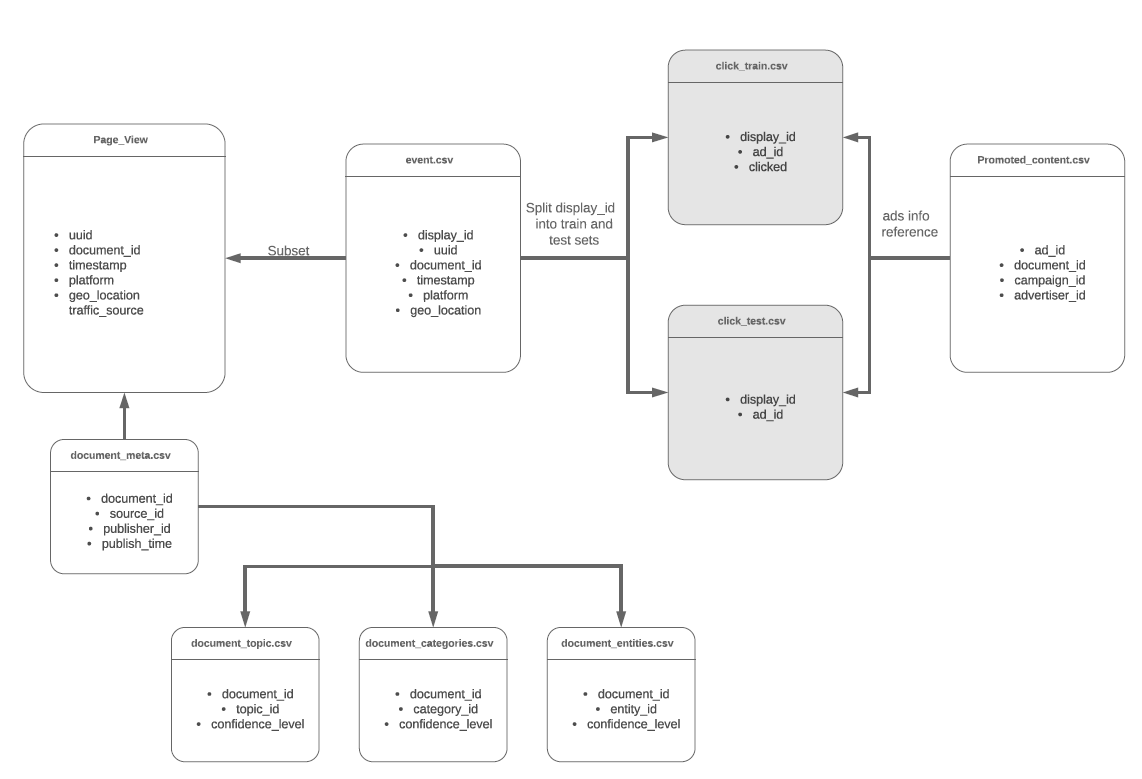

## Loading click_train.csv

In [43]:
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [44]:
click_train_schema = StructType(
                    [StructField("diplay_id", IntegerType(), True),
                    StructField("ad_id", IntegerType(), True),
                    StructField("clicked", IntegerType(), True)]
                    )

click_train_df = spark.read.schema(click_train_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("s3://clickprediction-trends/click_train/clicks_train.csv")

In [46]:
click_train_df.show()

+---------+------+-------+
|diplay_id| ad_id|clicked|
+---------+------+-------+
|        1| 42337|      0|
|        1|139684|      0|
|        1|144739|      1|
|        1|156824|      0|
|        1|279295|      0|
|        1|296965|      0|
|        2|125211|      0|
|        2|156535|      0|
|        2|169564|      0|
|        2|308455|      1|
|        3| 71547|      0|
|        3| 95814|      0|
|        3|152141|      0|
|        3|183846|      0|
|        3|228657|      1|
|        3|250082|      0|
|        4|149930|      0|
|        4|153623|      1|
|        4|184709|      0|
|        4|186849|      0|
+---------+------+-------+
only showing top 20 rows

In [50]:
click_train_df.count()

87141731

In [51]:
click_train_df.select("ad_id").distinct().count()

478950

## Loading promoted_content.csv

In [48]:
promoted_content_schema = StructType(
                    [StructField("ad_id", IntegerType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("campaign_id", IntegerType(), True),
                    StructField("advertiser_id", IntegerType(), True)]
                    )

promoted_content_df = spark.read.schema(promoted_content_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("s3://clickprediction-trends/promoted_content/promoted_content.csv")

In [49]:
promoted_content_df.show()

+-----+-----------+-----------+-------------+
|ad_id|document_id|campaign_id|advertiser_id|
+-----+-----------+-----------+-------------+
|    1|       6614|          1|            7|
|    2|     471467|          2|            7|
|    3|       7692|          3|            7|
|    4|     471471|          2|            7|
|    5|     471472|          2|            7|
|    6|      12736|          1|            7|
|    7|      12808|          1|            7|
|    8|     471477|          2|            7|
|    9|      13379|          1|            7|
|   10|      13885|          1|            7|
|   11|      14230|          1|            7|
|   12|     446701|         10|           19|
|   13|     471499|         10|           19|
|   14|     471500|         10|           19|
|   15|     471501|         10|           19|
|   16|     471514|         17|           19|
|   17|     471517|         10|           19|
|   18|     471518|         10|           19|
|   19|     471519|          5|   

# Calculating CTR of each ad in click_train.csv

We defined a new DataFrame grouping rows by ad_id and aggregating the sum of clicks and count of views. The processing of the CTR is made by a UDF (User Defined Function) named ctr_udf. The snippet output is a table with a sample of 10 ad_ids and their respective #clicks, #views e CTR.

In [52]:
ctr_udf = F.udf(lambda clicks, views: clicks / float(views), FloatType())

ad_id_avg_ctr_df = click_train_df.groupby('ad_id').agg(F.sum('clicked').alias('clicks'),                                                     
                                     F.count('*').alias('views')) \
                                .withColumn('ctr', ctr_udf('clicks','views'))
    
ad_id_avg_ctr_df.show(10)

+------+------+-----+----------+
| ad_id|clicks|views|       ctr|
+------+------+-----+----------+
| 31367| 18838|50338| 0.3742302|
| 93319|   453| 5121|0.08845928|
|157384|    32|  544|0.05882353|
|111381|     1|   15|0.06666667|
| 80033|  6104|18315|0.33327875|
|235447|  1256|19431|0.06463898|
| 78440|    53|  160|   0.33125|
|121763|   208| 1468|0.14168938|
| 14570|    30|   72|0.41666666|
|267699|   492| 5302|0.09279517|
+------+------+-----+----------+
only showing top 10 rows

To increase the CTR confidence, we have considered only ads with more than five views. With the collectAsMap() action, the distributed collection is converted to an in-memory lookup dictionary, whose key is the ad_id and the value is the corresponding average CTR.

In [53]:
ad_id_avg_ctr_dict = ad_id_avg_ctr_df.filter('views >= 5').select('ad_id', 'ctr', 'views') \
                    .rdd.map(lambda x: (x['ad_id'], x['ctr'])).collectAsMap()

In [55]:
print(ad_id_avg_ctr_dict[35982])

0.3194444477558136

In [60]:
ad_id_avg_ctr_df = ad_id_avg_ctr_df.filter('views >= 5')

ad_id_avg_ctr_df.show(10)

+------+------+-----+-----------+
| ad_id|clicks|views|        ctr|
+------+------+-----+-----------+
| 31367| 18838|50338|  0.3742302|
| 12046|  1031| 7866| 0.13107044|
|143032|    42|  197| 0.21319798|
|134138|  1546| 8212| 0.18826108|
|436516|   375| 5949|  0.0630358|
|235447|  1256|19431| 0.06463898|
|153409|   610|12142| 0.05023884|
|474110|     4|   37| 0.10810811|
|180910|    94| 4587|0.020492697|
|188834|  1022| 8873| 0.11518089|
+------+------+-----+-----------+
only showing top 10 rows

Merge back with original click_train file, fill 0 with the ads that don't have ctr.

In [61]:
ad_id_avg_ctr_df.count()

255975

In [69]:
255975/478950

0.5344503601628563

Adjust column names to avoid arbitary column names when joining tables

In [81]:
from pyspark.sql.functions import col

ad_id_avg_ctr_df = ad_id_avg_ctr_df.select(col("ad_id").alias("unique_ad_id"),col('clicks'),col('views'), col("ctr").alias('avg_ctr'))
ad_id_avg_ctr_df.show()

+------------+------+-----+-----------+
|unique_ad_id|clicks|views|    avg_ctr|
+------------+------+-----+-----------+
|       31367| 18838|50338|  0.3742302|
|       12046|  1031| 7866| 0.13107044|
|      143032|    42|  197| 0.21319798|
|      134138|  1546| 8212| 0.18826108|
|      436516|   375| 5949|  0.0630358|
|      235447|  1256|19431| 0.06463898|
|      153409|   610|12142| 0.05023884|
|      474110|     4|   37| 0.10810811|
|      180910|    94| 4587|0.020492697|
|      188834|  1022| 8873| 0.11518089|
|       92834|   177| 1127| 0.15705413|
|      241012|   609| 4281| 0.14225648|
|      155251|  1300| 5624|  0.2311522|
|      207103|   138|  692| 0.19942197|
|      186039|   331|  999| 0.33133134|
|       93319|   453| 5121| 0.08845928|
|      428490|    78| 2048|0.038085938|
|       96393|    96|  374| 0.25668448|
|      171946|   588| 1659| 0.35443038|
|      189488|    71|  435|  0.1632184|
+------------+------+-----+-----------+
only showing top 20 rows

In [96]:
merged_df = click_train_df.join(ad_id_avg_ctr_df, click_train_df.ad_id == ad_id_avg_ctr_df.unique_ad_id, how='left')
merged_df.show()

+---------+-----+-------+------------+------+-----+-------+
|diplay_id|ad_id|clicked|unique_ad_id|clicks|views|avg_ctr|
+---------+-----+-------+------------+------+-----+-------+
|  3678937|  148|      0|         148|     0|    9|    0.0|
|  3783605|  148|      0|         148|     0|    9|    0.0|
|  4349019|  148|      0|         148|     0|    9|    0.0|
|  3195987|  148|      0|         148|     0|    9|    0.0|
|  3262691|  148|      0|         148|     0|    9|    0.0|
|  3267986|  148|      0|         148|     0|    9|    0.0|
|  9944564|  148|      0|         148|     0|    9|    0.0|
|  8869255|  148|      0|         148|     0|    9|    0.0|
|  8944408|  148|      0|         148|     0|    9|    0.0|
|  9816155|  471|      0|         471|     0|    6|    0.0|
|  9989711|  471|      0|         471|     0|    6|    0.0|
| 10165719|  471|      0|         471|     0|    6|    0.0|
| 10182337|  471|      0|         471|     0|    6|    0.0|
|  9393604|  471|      0|         471|  

In [97]:
final_df = merged_df.drop('unique_ad_id','clicks','views')
final_df = final_df.na.fill(0)

+---------+-----+-------+-------+
|diplay_id|ad_id|clicked|avg_ctr|
+---------+-----+-------+-------+
|  3678937|  148|      0|    0.0|
|  3783605|  148|      0|    0.0|
|  4349019|  148|      0|    0.0|
|  8869255|  148|      0|    0.0|
|  8944408|  148|      0|    0.0|
|  3195987|  148|      0|    0.0|
|  3262691|  148|      0|    0.0|
|  3267986|  148|      0|    0.0|
|  9944564|  148|      0|    0.0|
|  9393604|  471|      0|    0.0|
|  9643855|  471|      0|    0.0|
|  9816155|  471|      0|    0.0|
|  9989711|  471|      0|    0.0|
| 10165719|  471|      0|    0.0|
| 10182337|  471|      0|    0.0|
| 11909639|  496|      0|    0.3|
| 13905068|  496|      1|    0.3|
| 14503527|  496|      1|    0.3|
| 14667568|  496|      0|    0.3|
| 14848616|  496|      0|    0.3|
+---------+-----+-------+-------+
only showing top 20 rows

In [98]:
final_df.show()

+---------+-----+-------+-------+
|diplay_id|ad_id|clicked|avg_ctr|
+---------+-----+-------+-------+
|  3195987|  148|      0|    0.0|
|  3262691|  148|      0|    0.0|
|  3267986|  148|      0|    0.0|
|  3678937|  148|      0|    0.0|
|  3783605|  148|      0|    0.0|
|  4349019|  148|      0|    0.0|
|  8869255|  148|      0|    0.0|
|  8944408|  148|      0|    0.0|
|  9944564|  148|      0|    0.0|
|  9393604|  471|      0|    0.0|
|  9643855|  471|      0|    0.0|
|  9816155|  471|      0|    0.0|
|  9989711|  471|      0|    0.0|
| 10165719|  471|      0|    0.0|
| 10182337|  471|      0|    0.0|
| 13905068|  496|      1|    0.3|
| 14503527|  496|      1|    0.3|
| 14667568|  496|      0|    0.3|
| 14848616|  496|      0|    0.3|
| 16602230|  496|      0|    0.3|
+---------+-----+-------+-------+
only showing top 20 rows

In [99]:
final_df.toPandas().to_csv('click_predict.csv')

An error was encountered:
Invalid status code '400' from http://ip-172-31-0-115.ec2.internal:8998/sessions/2/statements/60 with error payload: {"msg":"requirement failed: Session isn't active."}


# Calculating Similarity between user preference and context

## Loading document_topics.csv

Here we calculate the similarity of 

In [58]:
doc_topic_schema = StructType(
                    [StructField("document_id", IntegerType(), True),
                    StructField("topic_id", IntegerType(), True),
                    StructField("confidence_level", DoubleType(), True)]
                    )

doc_topic_df = spark.read.schema(doc_topic_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("s3://clickprediction-trends/document_topics/documents_topics.csv")

In [59]:
doc_topic_df.show()

+-----------+--------+-------------------+
|document_id|topic_id|   confidence_level|
+-----------+--------+-------------------+
|    1595802|     140| 0.0731131601068925|
|    1595802|      16| 0.0594164867373976|
|    1595802|     143| 0.0454207537554526|
|    1595802|     170| 0.0388674285182961|
|    1524246|     113|  0.196450402209685|
|    1524246|     260|   0.14287816210395|
|    1524246|      92| 0.0331591277639303|
|    1524246|     168| 0.0140903418233461|
|    1524246|      54|0.00878222028049753|
|    1524246|     207|0.00828237207366929|
|    1617787|     113|  0.216892316441472|
|    1617787|     260|  0.096312506979167|
|    1617787|     258| 0.0487299672992729|
|    1617787|      10| 0.0311358537054966|
|    1617787|     168| 0.0131200552985547|
|    1617787|     148| 0.0131103270369802|
|    1615583|      89|  0.316306499636243|
|    1615583|     198| 0.0157218239706048|
|    1615460|     260| 0.0979641463762194|
|    1615460|      26| 0.0145508920589849|
+----------

Create a document-topic matrix for calculating the cosine similarity between the document topics

In [70]:
topic_transformed = doc_topic_df.groupBy("document_id").pivot("topic_id").sum("confidence_level")
oldColumns = topic_transformed.schema.names
# add prefix
newColumns = [ 'topic_'+ c if c.isnumeric() else c for c in oldColumns]
result_df = topic_transformed.toDF(*newColumns)
result_df = result_df.na.fill(0)

In [73]:
result_df.select('document_id', 'topic_0', 'topic_1').show()

+-----------+-------+-------------------+
|document_id|topic_0|            topic_1|
+-----------+-------+-------------------+
|     873883|    0.0|                0.0|
|     457666|    0.0|                0.0|
|     429272|    0.0|                0.0|
|    1752013|    0.0|                0.0|
|    1488487|    0.0|0.00985907742867062|
|    2762201|    0.0|                0.0|
|     930790|    0.0|                0.0|
|    1144012|    0.0|                0.0|
|     425639|    0.0|                0.0|
|      14570|    0.0|                0.0|
|     860679|    0.0|                0.0|
|     626706|    0.0|                0.0|
|    1439727|    0.0|                0.0|
|    1648530|    0.0|                0.0|
|    2047658|    0.0|                0.0|
|    1068515|    0.0|                0.0|
|    1228151|    0.0|                0.0|
|    1299663|    0.0|                0.0|
|     942782|    0.0|                0.0|
|    2957628|    0.0|                0.0|
+-----------+-------+-------------

In [ ]:
from pyspark.sql.functions import col
from numpy import dot
from numpy.linalg import norm
doc1 = 1488264
doc2 = 288473
test_df = result_df.filter((col('document_id') == doc1) | (col('document_id') == doc2) )


In [ ]:
# the df that 1st col is the document_id col, all the other following cols are topics
def cos_sim(df, doc1, doc2):
  selected_df = df.filter((col('document_id') == doc1) | (col('document_id') == doc2)).toPandas()
  data_value = selected_df.iloc[:,1:].values
  a = data_value[0]
  b = data_value[1]
  cos_sim = dot(a, b)/(norm(a)*norm(b))
  return cos_sim

In [ ]:
cos_sim(result_df, doc1, doc2)

## Loading page_views.csv

All the datasets are read from AWS S3 Cloud Storage, a distributed filesystem like HDFS stored externally to the EMR cluster.

In [5]:
page_views_schema = StructType(
                    [StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True),
                    StructField("traffic_source", IntegerType(), True)]
                    )

page_views_df = spark.read.schema(page_views_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("s3://clickprediction-trends/page_views_sample/page_views_sample.csv")

In [6]:
page_views_df.rdd.getNumPartitions()

8

Spark sets the number of partitions based on file size, in this sample case, 8 partitions, each with about ~125MB. During job processing each partition becomes a task, which are processed in parallel by the available executors on Spark worker nodes.

In [7]:
page_views_df.show()

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
|2aa611f32875c7|        120| 71495491|       1|       CA>ON|             2|
|f55a6eaf2b34ab|        120| 73309199|       1|       BR>27|             2|
|cc01b582c8cbff|        120| 50033577|       1|       CA>BC|             2|
|6c802978b8dd4d|        120| 66590306|       1|       CA>ON|             2|
|f4e423314303ff|        120| 48314254|       1|   US>LA>622|             1|
|3937372ca27

### 1) Dealing with Timestamps

In [8]:
page_views_timestamp_stats_df = page_views_df.describe('timestamp')
page_views_timestamp_stats = page_views_timestamp_stats_df.rdd.collectAsMap()
page_views_timestamp_stats

{'count': '9999999', 'mean': '4.915974918146362E7', 'stddev': '2.2154451902183972E7', 'min': '12', 'max': '86399982'}

Total Page view records in this sample dataset

In [9]:
page_views_count = int(page_views_timestamp_stats['count'])
print('# Page Views:',page_views_count)

# Page Views: 9999999

In [8]:
from datetime import datetime
def convert_odd_timestamp(timestamp_ms_relative):
    TIMESTAMP_DELTA=1465876799998
    return datetime.fromtimestamp((int(timestamp_ms_relative)+TIMESTAMP_DELTA)//1000)

In [9]:
print(convert_odd_timestamp(page_views_timestamp_stats['min']))

2016-06-14 04:00:00

In [10]:
print(convert_odd_timestamp(page_views_timestamp_stats['max']))

2016-06-15 03:59:59

The sample dataset only contain data within one day.

## Loading events.csv

events.csv provides information on the display_id context. It covers both the train and test set.
1. Merging event and click_train will be able to analyze what type of documents(web page) users have at least 1 click
2. To get the info of all the documents, including the ones that have no ad click and the ones that have at least 1 click, we will need to left join page_view.csv and event.csv on uuid and document_id. The clicked column of those displays (uuid and document_id combo) that have no click action should be filled with 0 mannually.
3.

In [17]:
events_schema = StructType(
                    [StructField("display_id", IntegerType(), True),
                    StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True)]
                    )

events_df = spark.read \
            .schema(events_schema) \
            .options(header='true', inferschema='false', nullValue='\\N') \
            .csv("s3://clickprediction-trends/events/events.csv").cache()

In [18]:
events_df.rdd.getNumPartitions()

10

In [19]:
events_df.show()

+----------+--------------+-----------+---------+--------+------------+
|display_id|          uuid|document_id|timestamp|platform|geo_location|
+----------+--------------+-----------+---------+--------+------------+
|         1|cb8c55702adb93|     379743|       61|       3|   US>SC>519|
|         2|79a85fa78311b9|    1794259|       81|       2|   US>CA>807|
|         3|822932ce3d8757|    1179111|      182|       2|   US>MI>505|
|         4|85281d0a49f7ac|    1777797|      234|       2|   US>WV>564|
|         5|8d0daef4bf5b56|     252458|      338|       2|       SG>00|
|         6|7765b4faae4ad4|    1773517|      395|       3|   US>OH>510|
|         7|2cc3f6457d16da|    1149661|      602|       2|   US>MT>762|
|         8|166fc654d73c98|    1330329|      638|       2|   US>PA>566|
|         9|9dddccf70f6067|    1772126|      667|       1|   US>FL>528|
|        10|b09a0e92aa4d17|     157455|      693|       1|          US|
|        11|602e210c5831e5|    1773230|      710|       3|   US>

Total number of events

In [20]:
events_count = events_df.count()
print('There are {}'.format(events_count), 'events' )

There are 23120126 events

Distinct users in events

In [21]:
distinct_events_users = events_df.agg(F.countDistinct("uuid").alias('count')).collect()[0]['count']
distinct_events_users

19794967

Average events by users

In [22]:
avg_events_by_user = events_count / float(distinct_events_users)
avg_events_by_user

1.1679800223966021

### 1) Creating a dummy columns on Page Views and Events datasets, which will be useful to filter matches in outer joins

When joining DataFrames, the resulting DataFrame keeps only one column for each of the join fields. Thus, we've included dummy columns (dummyPageView, dummyEvent) on each dataset to be able to identify rows where there is a match (both dummy columns filled). Otherwise, only one of dummy columns will be filled and the other will be None (because its an outer join).

In [23]:
page_views_df = page_views_df.withColumn('dummyPageView', F.lit(1))
events_df = events_df.withColumn('dummyEvent', F.lit(1))

### 2) Performing a join between page views and events, on fields uuid and document_id

Here we perform an outer join between page_views.csv and events.csv datasets, on uuid and document_id fields. The objective is to explore rows matches, and see if events dataset subset is a subset of page views.

In [24]:
page_views_events_joined_by_uuid_document_df = page_views_df.alias('page_views').join(events_df.alias('events'), on=['uuid','document_id'], how='outer')

Count of events without a match on page views (0). We can see that all combinations of (uuid, document_id) events are represented on page views dataset.

In [25]:
page_views_events_joined_by_uuid_document_df.filter('dummyEvent is not null and dummyPageView is null').count()

22990388

In the matches (uuid, document_id) table below, we can see that for (uuid=10012c47f7317b, document_id=2897953) there are two records on Page Views (left side), but only one record in Events (right side), repeated with display_id=21485757.
As the fields platform (3) and geo_location (US>CO>751) are also equal, this suggests that timestamp is important when joining page views and events, as the user might visit a page more than once, at different times.

In [29]:
page_view_events_matches_df = page_views_events_joined_by_uuid_document_df.filter('dummyPageView is not null and dummyEvent is not null')
page_view_events_matches_df.show(200)

+--------------+-----------+---------+--------+------------+--------------+-------------+----------+----------+--------+------------+----------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|dummyPageView|display_id| timestamp|platform|geo_location|dummyEvent|
+--------------+-----------+---------+--------+------------+--------------+-------------+----------+----------+--------+------------+----------+
|107d782db58ecd|      60164| 36055596|       1|   US>TX>641|             1|            1|    990347|  60990241|       1|   US>TX>641|         1|
|10d5f6e5588450|    1767390| 62268660|       1|   US>GA>524|             1|            1|   1017278|  62268660|       1|   US>GA>524|         1|
|11c33317b53cd9|    1796937| 57047846|       2|   US>MA>506|             1|            1|    902868|  57047846|       2|   US>MA>506|         1|
|1243417cbf7cb1|    1772277| 81551746|       2|       CA>ON|             2|            1|   1365379|  81551746|       2|       CA>

### 3) Performing a join between page views and events, on fields uuid, document_id, platform, and geo_location

Here we left join events and page views datasets on uuid, document_id, platform, and geo_location.
There are 26323644 rows in the joined dataset, but events dataset has fewer rows (23120126) suggesting that those four fields does not uniquely join the datasets, because some events rows are duplicated to match page views.

In [31]:
events_with_day_df.alias('events').join(page_views_with_day_df.alias('page_views'), on=['uuid','document_id','platform','geo_location'], how='left').count()

name 'events_with_day_df' is not defined
Traceback (most recent call last):
NameError: name 'events_with_day_df' is not defined



### 4) Performing a join between page views and events, on fields uuid, document_id and timestamp

Let's try to join datasets now considering uuid, document_id and timestamp

In [ ]:
page_views_events_joined_by_uuid_document_timestamp_df  = events_df.alias('events') \
                                                            .join(page_views_df.alias('page_views'), 
                                                                   on=['uuid','document_id','timestamp'], 
                                                                   how='left')
page_views_events_joined_by_uuid_document_timestamp_df.filter('dummyEvent is not null and dummyPageView is not null').count()

We can see that joining on those 3 fields we have 15854250 matches. This is only 68% of the total 23120126 events, so timestamps between page views and events appears not to be exactly aligned.

### 5) Performing the join on fields uuid, document_id, platform, geo_location and day(timestamp)

As we have a delta between page views and events timestamps, we extract the dates from timestamps (ignoring hours) from both datasets

In [ ]:
truncate_day_from_timestamp_udf = F.udf(lambda ts: int(ts / 1000 / 60 / 60 / 24), IntegerType())
page_views_with_day_df = page_views_df.withColumn('day', truncate_day_from_timestamp_udf('timestamp')).withColumn('dummyPageView', F.lit(1))
events_with_day_df = events_df.withColumn('day', truncate_day_from_timestamp_udf('timestamp')).withColumn('dummyEvent', F.lit(1))

Now we join the datasets on fields uuid, document_id, platform, geo_location and day(timestamp).
This join approach appears to be reasonable, because there are 23120126 resulting rows (exactly the events count, with no duplication) and the count of rows where events have no corresponding page view is 55568 (only 0.24% of events)

In [ ]:
page_views_events_with_day_joined_df = events_with_day_df.alias('events').join(page_views_with_day_df.alias('page_views'), on=['uuid','document_id','platform','geo_location','day'], how='left')
page_views_events_with_day_joined_df.count()

## Analyzing users' additional page views not in events

The main reason for the usage of page views dataset is that it might provide additional user logs when compaired to events dataset, that could help us to model users preferences or interests. Let's test this hypothesis.

In [ ]:
#Registering events dataset as a view, to use it in a SQL query
events_with_day_df.createOrReplaceTempView("EVENTS")    

#Registering "page_views left join events dataset" as a view, to use it in a SQL query
page_views_left_join_events_df = page_views_with_day_df.alias('page_views') \
                                        .join(events_with_day_df.alias('events'), 
                                              on=['uuid','document_id','platform','geo_location','day'], 
                                              how='left')
page_views_left_join_events_df.createOrReplaceTempView("PAGE_VIEWS_LEFT_JOIN_EVENTS")

#Grouping how many users have exactly N additional page views (which are not in events dataset, 
#                                                              but only from users in events dataset)
additional_page_views_by_user_df = spark.sql('''
            SELECT additionalPageViewsByUser, COUNT(*) as usersCount FROM
                (SELECT UUID, COUNT(*) as additionalPageViewsByUser 
                FROM PAGE_VIEWS_LEFT_JOIN_EVENTS p 
                WHERE dummyEvent IS NULL
                  AND EXISTS (SELECT uuid FROM EVENTS where uuid = p.uuid) 
                GROUP BY UUID)
            GROUP BY additionalPageViewsByUser''')

In [ ]:
additional_page_views_by_user_pandas = additional_page_views_by_user_df.toPandas()
additional_page_views_by_user_pandas = additional_page_views_by_user_pandas.set_index('additionalPageViewsByUser').sort_index()
additional_page_views_by_user_pandas.head(10)

There are 14951413 (about 75%) users in events dataset which have at least one additional page view (besides the ones logged as events), and 4843554 (about 25%) users with no additional page view.

In [ ]:
additional_page_views_by_user_pandas.head(20).plot.bar(y='usersCount')

In [ ]:
additional_page_views_by_user_pandas['cum_perc'] = (additional_page_views_by_user_pandas['usersCount'].cumsum() / users_with_additional_page_views_count) * 100
additional_page_views_by_user_pandas.head(10)

## Calculating Click Through Rate